In [ ]:
# Instalar las librerías necesarias, incluyendo imbalanced-learn para manejar el desbalance de datos
!pip install -U imbalanced-learn pandas scikit-learn seaborn matplotlib

# Importar las librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Montar Google Drive para acceder a tus archivos
drive.mount('/content/drive')

# Ruta al archivo CSV
file_path = '/content/drive/My Drive/Customer-Churn-Records.csv'

# Cargar el dataset en un DataFrame de Pandas
df = pd.read_csv(file_path)

# Mostrar las primeras 5 filas para verificar
print("Primeras 5 filas del dataset:")
print(df.head())

  Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Primeras 5 filas del dataset:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00  

In [ ]:
# Eliminar columnas irrelevantes para el modelo
df = df.drop(['Complain'], axis=1)

# Identificar todas las columnas categóricas después de la limpieza inicial
# Esto es crucial para evitar el error de ValueError
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Codificar todas las variables categóricas con One-Hot Encoding
print(f"Columnas categóricas a codificar: {categorical_cols}")
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separar características (X) y variable objetivo (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# Escalar variables numéricas restantes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Mostrar el DataFrame preprocesado y listo para el modelado
print("\nDataFrame después del preprocesamiento:")
print(X.head())

# Mostrar la distribución original de la variable objetivo
print("\nDistribución de la clase 'Exited' original:")
print(y.value_counts(normalize=True) * 100)

Columnas categóricas a codificar: []

DataFrame después del preprocesamiento:
   CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.326221  0.293517 -1.041760 -1.225848      -0.911583   0.646092   
1    -0.440036  0.198164 -1.387538  0.117350      -0.911583  -1.547768   
2    -1.536794  0.293517  1.032908  1.333053       2.527057   0.646092   
3     0.501521  0.007457 -1.387538 -1.225848       0.807737  -1.547768   
4     2.063884  0.388871 -1.041760  0.785728      -0.911583   0.646092   

   IsActiveMember  EstimatedSalary  Satisfaction Score  Point Earned  \
0        0.970243         0.021886           -0.721130     -0.630839   
1        0.970243         0.216534           -0.009816     -0.666251   
2       -1.030670         0.240687           -0.009816     -1.015942   
3       -1.030670        -0.108918            1.412812     -1.135457   
4        0.970243        -0.365276            1.412812     -0.803472   

   Gender_Male  Geography_Germany  Geography

In [ ]:
# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDistribución de la clase 'Exited' en el conjunto de entrenamiento original: {Counter(y_train)}")

# Aplicar SMOTE para sobremuestrear la clase minoritaria en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Distribución de la clase 'Exited' en el conjunto de entrenamiento después de SMOTE: {Counter(y_train_res)}")


Distribución de la clase 'Exited' en el conjunto de entrenamiento original: Counter({0: 6370, 1: 1630})
Distribución de la clase 'Exited' en el conjunto de entrenamiento después de SMOTE: Counter({0: 6370, 1: 6370})


In [ ]:
# Inicializar y entrenar el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

print("\n¡Modelo Random Forest entrenado con datos balanceados con éxito!")


¡Modelo Random Forest entrenado con datos balanceados con éxito!



Matriz de Confusión:
[[1449  143]
 [ 162  246]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1592
           1       0.63      0.60      0.62       408

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.84      0.85      0.85      2000



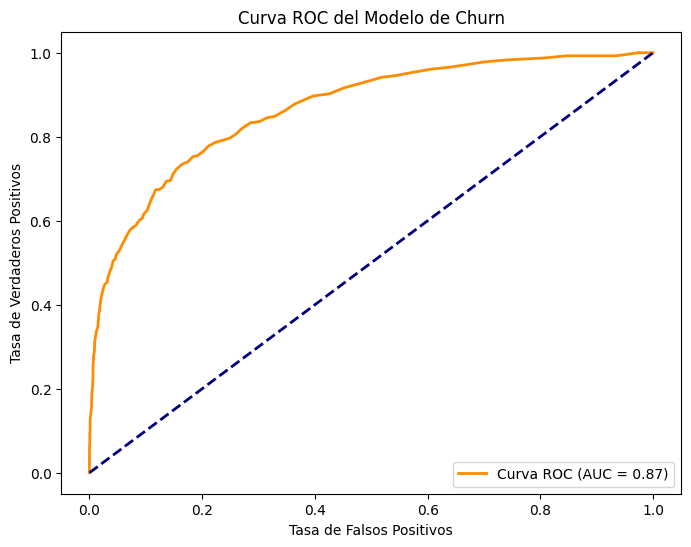


Importancia de las características (Top 10):
Age                   0.232904
NumOfProducts         0.169918
Balance               0.098863
Point Earned          0.070323
EstimatedSalary       0.069889
CreditScore           0.066501
Satisfaction Score    0.058228
Tenure                0.058064
IsActiveMember        0.052465
Gender_Male           0.032364
dtype: float64


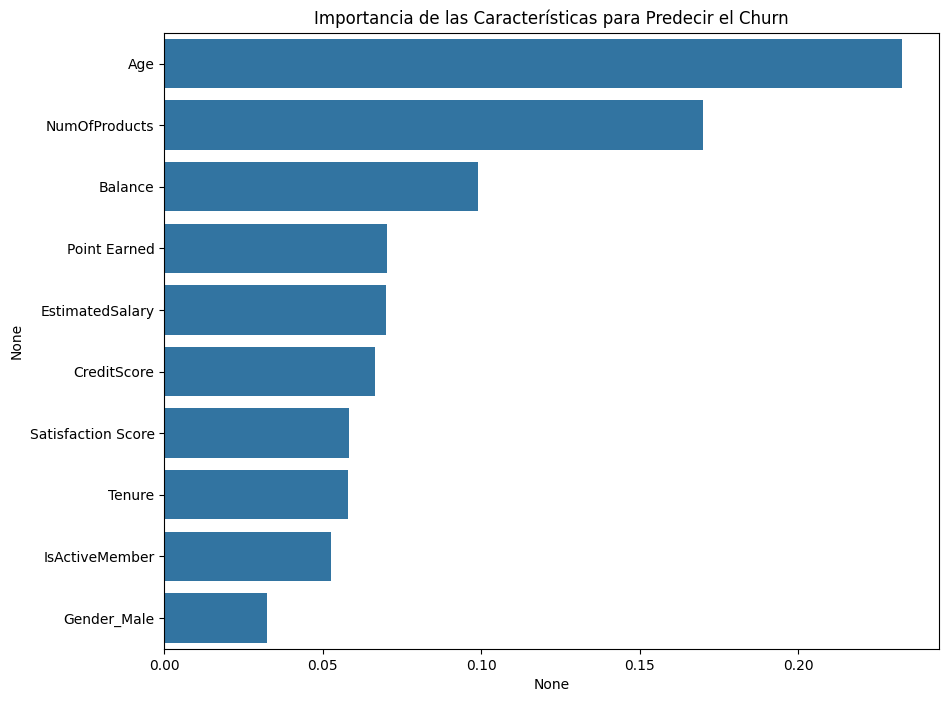

In [ ]:
# Predecir los resultados en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Matriz de Confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Reporte de Clasificación (Precisión, Recall, F1-Score)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Modelo de Churn')
plt.legend(loc='lower right')
plt.show()

# Importancia de las características
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nImportancia de las características (Top 10):")
print(feature_importances.head(10))

# Visualizar la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)
plt.title('Importancia de las Características para Predecir el Churn')
plt.show()

--- Entrenando y evaluando el Árbol de Decisión ---

Matriz de Confusión del Árbol de Decisión:
[[1334  258]
 [ 168  240]]

Reporte de Clasificación del Árbol de Decisión:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1592
           1       0.48      0.59      0.53       408

    accuracy                           0.79      2000
   macro avg       0.69      0.71      0.70      2000
weighted avg       0.81      0.79      0.79      2000



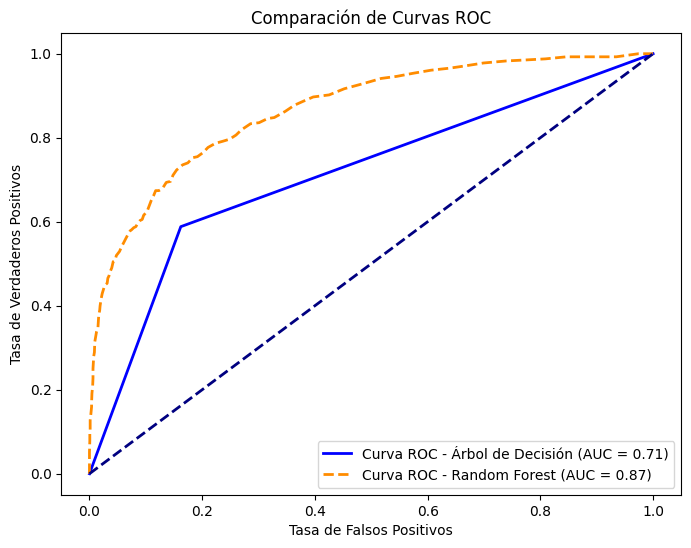

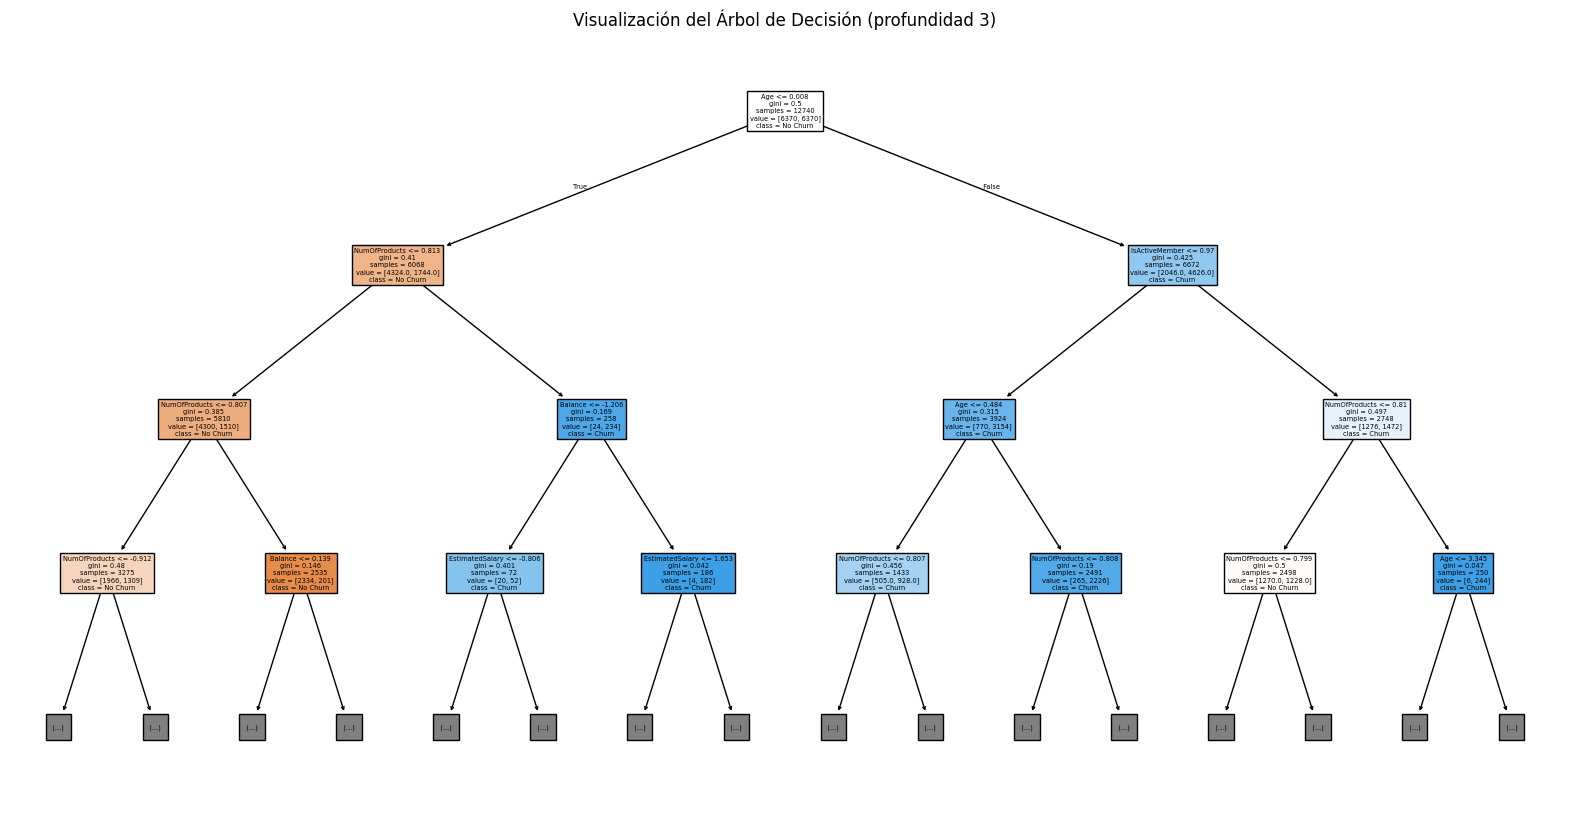

In [ ]:
# Importar la librería necesaria
from sklearn.tree import DecisionTreeClassifier

print("--- Entrenando y evaluando el Árbol de Decisión ---")

# Inicializar el modelo de Árbol de Decisión
# Usamos los mismos parámetros que el Random Forest por consistencia,
# aunque el modelo solo toma el random_state para la reproducibilidad
dt_model = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo con los datos balanceados (SMOTE)
dt_model.fit(X_train_res, y_train_res)

# Predecir los resultados en el conjunto de prueba original
dt_pred = dt_model.predict(X_test)
dt_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# --- Evaluación del Modelo ---

# Matriz de Confusión
print("\nMatriz de Confusión del Árbol de Decisión:")
print(confusion_matrix(y_test, dt_pred))

# Reporte de Clasificación (Precisión, Recall, F1-Score)
print("\nReporte de Clasificación del Árbol de Decisión:")
print(classification_report(y_test, dt_pred))

# Curva ROC y AUC
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_pred_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Curva ROC - Árbol de Decisión (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr, tpr, color='darkorange', lw=2, linestyle='--', label=f'Curva ROC - Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc='lower right')
plt.show()

# Opcional: Visualización del Árbol de Decisión (muy útil para la tesis)
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=['No Churn', 'Churn'], max_depth=3)
plt.title("Visualización del Árbol de Decisión (profundidad 3)")
plt.show()

--- Entrenando y evaluando el Super Vector Machine (SVM) ---

Matriz de Confusión del Super Vector Machine (SVM):
[[1295  297]
 [ 127  281]]

Reporte de Clasificación del Super Vector Machine (SVM):
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1592
           1       0.49      0.69      0.57       408

    accuracy                           0.79      2000
   macro avg       0.70      0.75      0.71      2000
weighted avg       0.82      0.79      0.80      2000



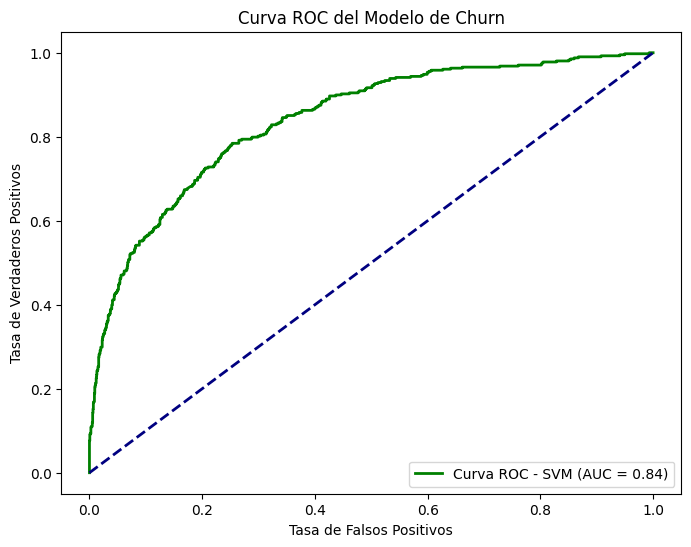

In [ ]:
# Importar la librería necesaria
from sklearn.svm import SVC

print("--- Entrenando y evaluando el Super Vector Machine (SVM) ---")

# Inicializar el modelo SVM
# SVM puede tomar más tiempo en entrenar que los otros modelos
# 'probability=True' es necesario para obtener las probabilidades y la curva ROC
# Se utiliza el kernel 'rbf' para manejar relaciones no lineales en los datos
svm_model = SVC(kernel='rbf', random_state=42, probability=True)

# Entrenar el modelo con los datos balanceados (SMOTE)
svm_model.fit(X_train_res, y_train_res)

# Predecir los resultados en el conjunto de prueba original
svm_pred = svm_model.predict(X_test)
svm_pred_proba = svm_model.predict_proba(X_test)[:, 1]

# --- Evaluación del Modelo ---

# Matriz de Confusión
print("\nMatriz de Confusión del Super Vector Machine (SVM):")
print(confusion_matrix(y_test, svm_pred))

# Reporte de Clasificación (Precisión, Recall, F1-Score)
print("\nReporte de Clasificación del Super Vector Machine (SVM):")
print(classification_report(y_test, svm_pred))

# Curva ROC y AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred_proba)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
# Gráfico del SVM
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'Curva ROC - SVM (AUC = {roc_auc_svm:.2f})')
# Puedes agregar los modelos anteriores para comparar en el mismo gráfico
# plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, linestyle='--', label=f'Curva ROC - Árbol de Decisión (AUC = {roc_auc_dt:.2f})')
# plt.plot(fpr, tpr, color='darkorange', lw=2, linestyle='--', label=f'Curva ROC - Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Modelo de Churn')
plt.legend(loc='lower right')
plt.show()

--- Entrenando y evaluando el modelo Naive Bayes ---

Matriz de Confusión del Naive Bayes:
[[1152  440]
 [ 122  286]]

Reporte de Clasificación del Naive Bayes:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1592
           1       0.39      0.70      0.50       408

    accuracy                           0.72      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.72      0.74      2000



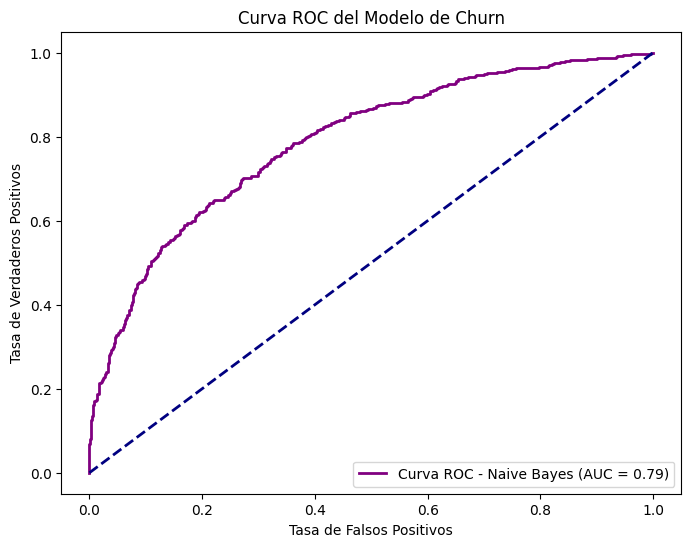

In [ ]:
# Importar la librería necesaria
from sklearn.naive_bayes import GaussianNB

print("--- Entrenando y evaluando el modelo Naive Bayes ---")

# Inicializar el modelo Naive Bayes (GaussianNB)
nb_model = GaussianNB()

# Entrenar el modelo con los datos balanceados (SMOTE)
nb_model.fit(X_train_res, y_train_res)

# Predecir los resultados en el conjunto de prueba original
nb_pred = nb_model.predict(X_test)
nb_pred_proba = nb_model.predict_proba(X_test)[:, 1]

# --- Evaluación del Modelo ---

# Matriz de Confusión
print("\nMatriz de Confusión del Naive Bayes:")
print(confusion_matrix(y_test, nb_pred))

# Reporte de Clasificación (Precisión, Recall, F1-Score)
print("\nReporte de Clasificación del Naive Bayes:")
print(classification_report(y_test, nb_pred))

# Curva ROC y AUC
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_pred_proba)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(8, 6))
# Gráfico de Naive Bayes
plt.plot(fpr_nb, tpr_nb, color='purple', lw=2, label=f'Curva ROC - Naive Bayes (AUC = {roc_auc_nb:.2f})')
# Puedes agregar los modelos anteriores para comparar en el mismo gráfico
# plt.plot(fpr_svm, tpr_svm, color='green', lw=2, linestyle='--', label=f'Curva ROC - SVM (AUC = {roc_auc_svm:.2f})')
# plt.plot(fpr, tpr, color='darkorange', lw=2, linestyle='--', label=f'Curva ROC - Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Modelo de Churn')
plt.legend(loc='lower right')
plt.show()